# Object Detection in Point Cloud: Lane Marking
### Description
Object detection in Point Cloud is popular in HD Map and sensor-based autonomous driving. There
basically four types of object you can obtain in daily scenario: road surface - contains painted lane
marking and pavement area, support facility - contains road boundary (guardrail and curb), road
sign, light pole, etc., uncorrelated object - for example, sidewalk, building, etc., and moving object -
such like pedestrian, vehicle, bicycle, etc.

In this project, please search references, design and prototype your lane marking detection
algorithm.

# Part 1: Map Projection
The point cloud data is written in latitude, and longitute which is hard to get distance between two points, computer angles, etc.

So here, our first step is to using a map projection which has nearly no distortion in the area of point cloud.

By https://epsg.io/?q=6875, we use 6875.

In [69]:
import time
import math
import pandas as pd
import matplotlib.pyplot as plt
import pyproj
import pptk
from pyproj import Transformer,transform
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
import numpy as np

In [70]:
transformer = Transformer.from_proj(4326,6875)

In [71]:
def transfer(lon,lat):
    long,lati = lon,lat
    x,y = transformer.transform(lati,long)
    return(x, y)

In [4]:
raw_data=pd.read_csv('C:/Users/zhaoxiangyu/Desktop/final_project_data/final_project_point_cloud.fuse',sep=' ',header=None,names=['latitude','longitude','altitude','intensity'])

In [64]:
data=raw_data.copy()

In [6]:
data.head()

,latitude,longitude,altitude,intensity
0,45.903883,11.028414,232.4648,10
1,45.903683,11.028221,234.4706,5
2,45.903683,11.028222,234.4459,7
3,45.903682,11.028224,234.4307,7
4,45.903681,11.028226,234.4232,7


In [7]:
data.shape

(430736, 4)

In [72]:
data['X'] = data.apply(lambda x: transfer(x['longitude'],x['latitude'])[1], axis=1)
data['Y'] = data.apply(lambda x: transfer(x['longitude'],x['latitude'])[0], axis=1)

# Part 2: Data Mining and Visualization

(array([4.07413e+05, 1.48390e+04, 7.04000e+03, 1.23100e+03, 1.26000e+02,
        5.20000e+01, 1.50000e+01, 3.00000e+00, 1.10000e+01, 6.00000e+00]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <a list of 10 Patch objects>)

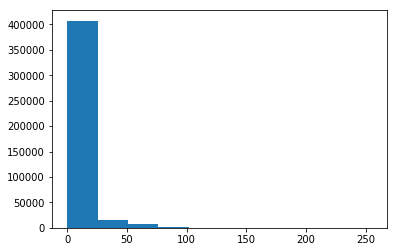

In [9]:
plt.hist(data['intensity'],range=(data['intensity'].min(),data['intensity'].max()))

(array([9.73500e+03, 7.30200e+03, 3.52262e+05, 4.82620e+04, 7.61900e+03,
        4.92700e+03, 1.63000e+02, 1.53000e+02, 1.27000e+02, 1.86000e+02]),
 array([221.8044 , 223.07449, 224.34458, 225.61467, 226.88476, 228.15485,
        229.42494, 230.69503, 231.96512, 233.23521, 234.5053 ]),
 <a list of 10 Patch objects>)

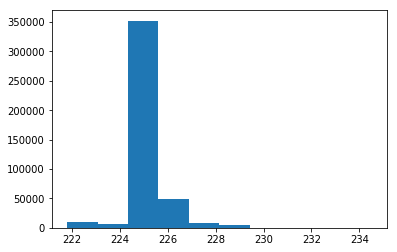

In [285]:
plt.hist(data['altitude'],range=(data['altitude'].min(),data['altitude'].max()))

# Part 3: A Small Tool for Observation

In [25]:
def pptk_visualization(data_x,data_y,scale_min,scale_max,rotation=False):
    v=pptk.viewer(data_x)
    v.attributes(data_y)
    v.color_map('jet',scale=[scale_min,scale_max])
    v.set(point_size=0.1)
    v.set(show_axis=False)

    camera_moved_x = 41.8
    camera_moved_y = 77.3


    # camera part
    poses = []
    camera_start_point_x=6924713
    camera_start_point_y=5078241
    camera_start_point_z=227.50
    if not rotation:
        frames=2
        for i in range(frames):
            poses.append([camera_start_point_x,camera_start_point_y,camera_start_point_z,math.atan(camera_moved_y/camera_moved_x)+np.pi ,1/10*np.pi ,100])
    else:
        frames=100
        poses.append([camera_start_point_x,camera_start_point_y,camera_start_point_z,2*np.pi/frames*i ,1/4*np.pi ,5])
        
    v.play(poses,1* np.arange(frames), repeat=True, interp='linear')
    return v,poses
def record(v,prefix):
    v.record('C:/Users/zhaoxiangyu/Desktop/final_project_data/recording', poses,prefix=prefix,fps=1)

In [50]:
viewer,poses=pptk_visualization(data[['X','Y','altitude']],data['intensity'],scale_min=0,scale_max=30)

In [20]:
record(viewer,prefix='Original_Data')

# Part 4: Lane Mark Detection

## Approch 1: Planarity Measures

### 1.1: Compute Planarity Measures
Pass 1: Compute surface normal approximation for each point (Using pptk, see below)

Pass 2: Compute the variance of normalswithin the neighborhood

#### 1.1.1 Using pptk (Point Processing Toolkit) compute normals

In [ ]:
normals_values=pptk.estimate_normals(points=data[['X','Y','altitude']].to_numpy(),k=300,r=1.5)

In [ ]:
normals= pd.DataFrame(normals_values)
normals.columns =['normal_x','normal_y','normal_z']

In [ ]:
normals.head()

In [ ]:
data=data.join(normals)

In [ ]:
data.head()

In [ ]:
data['normal']=data.apply(lambda x: np.array([x['normal_x'],x['normal_y'],x['normal_z']]),axis=1)

In [ ]:
data.head()

#### 1.1.2 Build k-d tree & Compute Planarity Measure (PM)

In [ ]:
tree=pptk.kdtree._build(data[['X','Y','altitude']].to_numpy())

In [ ]:
xyz=data[['X','Y','altitude']].values

In [ ]:
# test
pptk.kdtree._query(tree,xyz[1:2],100,1)

In [ ]:
def query_kd(point_xyz):
    return pptk.kdtree._query(tree,point_xyz,100,1)
## Parameters:
# tree (capsule object) – A k-d tree as produced by kdtree._build.
# queries (numpy array) – Specify query points by one of the ways above.
# k (int, optional) – Default: 1
# dmax (float or double, optional) – Default: inf

In [ ]:
def angle(X,Y):
    m=np.dot(X,Y)
    temp=m/(np.sum(X**2)**(1/2))/(np.sum(Y**2)**(1/2))
    if temp >1 or temp <-1:
        return math.acos(0)
    return math.acos(abs(temp))

In [ ]:
data['PM']=np.nan
for i in range(data.shape[0]):
    total = 0
    PM = 0
    temp_ind = query_kd(xyz[i:i+1])[0]
    if len(temp_ind)<10:
        PM = 3
    else:
        for ind in temp_ind:
            total+=data['normal'][ind]
        avg = total/len(temp_ind)
        for ind in temp_ind:
            PM += angle(data['normal'][ind],avg)**2
        PM = PM/len(temp_ind)
    data.at[i,'PM']=PM
    if i % 10000==0:
        if i !=0:
            end=time.time()
            print('{:d} ,{:.7f} '.format( i, (end-start)))
        else:
            start=time.time()

In [ ]:
data.head()

In [ ]:
data.PM.mean()

In [ ]:
data.PM[data.PM!=10].max()

In [ ]:
data.PM.min()

In [ ]:
data['PM_10']=data['PM']*10

In [ ]:
data.head()

In [ ]:
xyzp=data[['X','Y','altitude','PM_10']].values.tolist()

#### 1.1.3 Using DBSACN to Classify the Road Plane

In [ ]:
clustering = DBSCAN(eps=0.2, min_samples=3).fit(xyzp)

In [ ]:
data['label']=clustering.labels_

In [ ]:
label=data['label'].value_counts().index[0]

In [ ]:
filtered_data=data.iloc[np.where((data['label']==label) & (data['intensity']>20))[0]]

In [ ]:
xyz=filtered_data[['X','Y','altitude']].values.tolist()
rgb=((filtered_data['altitude']).tolist())
v = pptk.viewer(xyz,rgb)
v.color_map('jet', scale=[min(rgb),max(rgb)])
v.set(point_size=0.1)

In [ ]:
filtered_data.index

In [ ]:
X=filtered_data[['X','Y','altitude']]

In [ ]:
pca = PCA(n_components=2)
pca.fit(X)

In [ ]:
X_new=pca.transform(X)
x=X_new[:,0]
y=X_new[:,1]
index=filtered_data.index

#### 1.1.4 Using RANSAC to Classify the Lane Mark on Road Plane

In [ ]:
def detect_lane_marking_pm(x,y,index):
    group=[]
    full_group=[]
    while len(y)>100:
        ransac = linear_model.RANSACRegressor(min_samples=2,residual_threshold=0.8)
        ransac.fit(x.reshape(-1, 1), y)
        inlier_mask = ransac.inlier_mask_
        outlier_mask = np.logical_not(inlier_mask)
        
        group.append(index[inlier_mask].tolist())
        plt.figure()
        plt.scatter(x[inlier_mask], y[inlier_mask], color='yellowgreen', marker='.',
                    label='Inliers')
        plt.scatter(x[outlier_mask], y[outlier_mask], color='gold', marker='.',
                    label='Outliers')
        x=x[outlier_mask]
        y=y[outlier_mask]
        index=index[outlier_mask]
    return group

In [ ]:
lane_group=detect_lane_marking_pm(x,y,index)

In [ ]:
data.to_pickle('point_cloud_zhan.pkl')

In [ ]:
data['lane_mark_pm']=-1
for i in range(len(lane_group)):
    data.at[lane_group[i],'lane_mark_pm']=i

## Approch 2: RANSAC (A more accurate and efficient method)

### 2.1 Surface Detection with RANSAC


In [47]:
xy=data[['X','Y']]
z=data[['altitude']]
index=data.index

In [45]:
def detect_road_surface(xy,z,index):
    group=[]
    for i in range(2):
        ransac = linear_model.RANSACRegressor(residual_threshold=0.05)
        ransac.fit(xy,z)
        inlier_mask = ransac.inlier_mask_
        outlier_mask = np.logical_not(inlier_mask)
        group.append(index[inlier_mask].tolist())
        xy=xy[outlier_mask]
        z=z[outlier_mask]
        index=index[outlier_mask]
    return group

In [48]:
road_suface_group = detect_road_surface(xy,z,index)

In [65]:
data['plane']=-1
for i in range(len(road_suface_group)):
    data.at[road_suface_group[i],'plane']=i

In [37]:
data.altitude.mean()

225.223176380429

In [66]:
# Filter and get all the points which are on the plane
plane_data_all=data[data.plane!=-1]
# Filter and get the points on the plane but with intensity over 20 
plane_data=plane_data_all[plane_data_all.intensity>20]
# Filter and get the points on the plane but with intensity lower than 20 
plane_data_rest=plane_data_all[plane_data_all.intensity<=20]

In [51]:
v=pptk.viewer(plane_data[['X','Y','altitude']])
v.attributes(plane_data['plane'])
v.set(point_size=0.3)
v.set(show_axis=False)
v.color_map('jet',scale=[-1,2])

# camera part
poses = []
camera_start_point_x=6924683
camera_start_point_y=5078211
camera_start_point_z=227.50
for i in range(100):
    poses.append([camera_start_point_x+i*0.5,camera_start_point_y+i*0.5,camera_start_point_z,5/4*np.pi ,1/12*np.pi ,30])


### 2.2 Inline Points Detection

In [52]:
#Select the x,y,z columns
X=plane_data[['X','Y','altitude']]
X_rest=plane_data_rest[['X','Y','altitude']]

In [53]:
pca = PCA(n_components=2)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [54]:
X_new=pca.transform(X)
X_rest_new=pca.transform(X_rest)
x=X_new[:,0]
y=X_new[:,1]
x_rest=X_rest_new[:,0]
y_rest=X_rest_new[:,1]
index=plane_data.index
index_rest=plane_data_rest.index

In [55]:
# Define the function to mark the lane with different group number
def detect_lane_marking(x,y,index):
    group=[]
    full_group=[]
    for i in range(8):
        ransac = linear_model.RANSACRegressor(min_samples=2,residual_threshold=0.7)
        ransac.fit(x.reshape(-1, 1), y)
        inlier_mask = ransac.inlier_mask_
        outlier_mask = np.logical_not(inlier_mask)
        
        group.append(index[inlier_mask].tolist())
        plt.figure()
        plt.scatter(x[inlier_mask], y[inlier_mask], color='yellowgreen', marker='.',
                    label='Inliers')
        plt.scatter(x[outlier_mask], y[outlier_mask], color='gold', marker='.',
                    label='Outliers')
        x=x[outlier_mask]
        y=y[outlier_mask]
        index=index[outlier_mask]
    return group

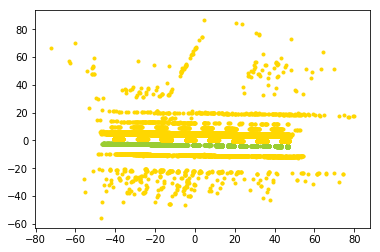

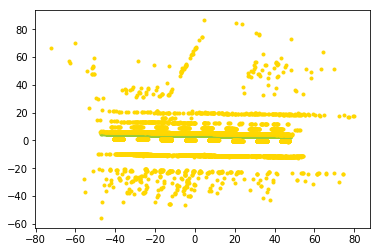

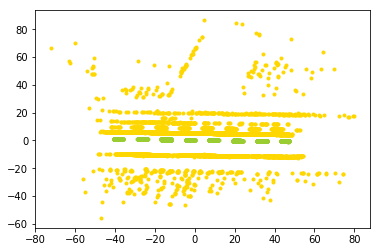

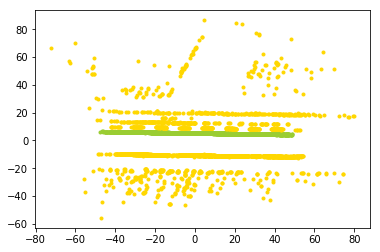

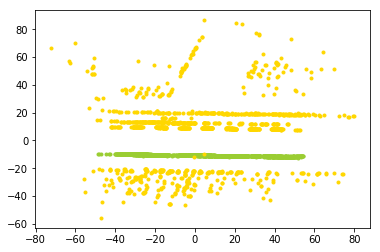

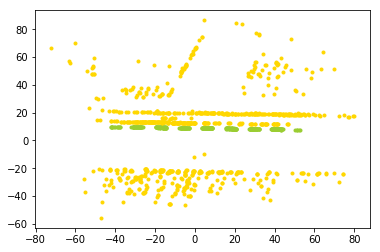

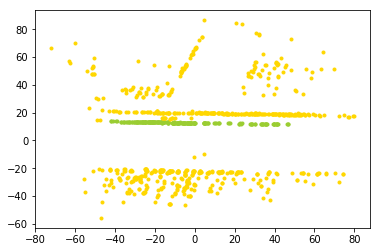

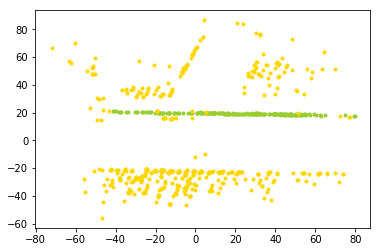

In [56]:
lane_group=detect_lane_marking(x,y,index)

### 2.3 Postprocessing Inline Points to Improve Smoothness

In [57]:
# Linear Regression for each lane in 3D space and return the linear models for each lane
def fit_line_in_3D():
    fit_3d_line=[]
    for i in range(8):
        temp_group=lane_group[i]
        temp_x=data.iloc[temp_group]['X']
        temp_y=data.iloc[temp_group]['Y']
        temp_z=data.iloc[temp_group]['altitude']
        x_y=LinearRegression().fit(temp_x.values.reshape(-1, 1), temp_y)
        x_z=LinearRegression().fit(temp_x.values.reshape(-1, 1), temp_z)
        fit_3d_line.append([x_y,x_z])
    return fit_3d_line

In [58]:
# Mark the plane points on virtual line corresponding to lane but not on actual lane. 
def mark_inline_point(residual_for_y,residual_for_z):
    for i in range(8):
        model_xy=fit_3d_line[i][0]
        model_xz=fit_3d_line[i][1]
        data_x=X_rest['X']
        prediction_y=model_xy.predict(data_x.values.reshape(-1, 1))
        prediction_z=model_xz.predict(data_x.values.reshape(-1, 1))
        residual_y=np.absolute(X_rest['Y']-prediction_y)
        residual_z=np.absolute(X_rest['altitude']-prediction_z)
        inline_id=residual_y.index[np.where((residual_y<residual_for_y) & (residual_z<residual_for_z))[0]]
        data.at[inline_id,'virtual_lane']=i
def adjust_actual_lane(residual_for_y,residual_for_z):
    for i in range(8):
        model_xy=fit_3d_line[i][0]
        model_xz=fit_3d_line[i][1]
        data_x=data.iloc[lane_group[i]]['X']
        prediction_y=model_xy.predict(data_x.values.reshape(-1, 1))
        prediction_z=model_xz.predict(data_x.values.reshape(-1, 1))
        residual_y=np.absolute(data.iloc[lane_group[i]]['Y']-prediction_y)
        residual_z=np.absolute(data.iloc[lane_group[i]]['altitude']-prediction_z)
        outline_id=residual_y.index[np.where((residual_y>residual_for_y) & (residual_z>residual_for_z))[0]]
        data.at[outline_id,'lane_mark']=-1

In [67]:
data['lane_mark']=-1
for i in range(len(lane_group)):
    data.at[lane_group[i],'lane_mark']=i
data['virtual_lane']=-1
data_actual_line=data[(data.plane!=-1) & (data.lane_mark!=-1)]

In [73]:
fit_3d_line=fit_line_in_3D()
mark_inline_point(0.1,0.1)
adjust_actual_lane(0.05,0.001)
data_plane_filtered_by_intensity=plane_data
data_plane=data[(data.plane!=-1)]
data_in_line=data[(data.plane!=-1) & ((data.virtual_lane!=-1)|(data.lane_mark!=-1))]

### 2.4 Observation and Output for Plane Data, Inline Data & Post-processing Data

In [39]:
viewer,poses=pptk_visualization(data_actual_line[['X','Y','altitude']],data_actual_line['lane_mark'],scale_min=-1,scale_max=7)

In [40]:
record(viewer,prefix='Inline_Data')

In [96]:
viewer,poses=pptk_visualization(data_plane[['X','Y','altitude']],data_plane['plane'],scale_min=-1,scale_max=2)

In [42]:
record(viewer,prefix='Plane_Data')

In [51]:
viewer,poses=pptk_visualization(data_in_line[['X','Y','altitude']],data_in_line['lane_mark'],scale_min=-1,scale_max=7)

In [44]:
record(viewer,prefix='Post_Processing_Data')

In [99]:
viewer,poses=pptk_visualization(data_plane_filtered_by_intensity[['X','Y','altitude']],data_plane_filtered_by_intensity['plane'],scale_min=-1,scale_max=2)

In [101]:
record(viewer,prefix='data_plane_filtered_by_intensity')

#### 2.4.1  For better performance of view in PPTK , we simulated the points on fitting lines to improve the brightness

In [105]:
fitting_data=pd.DataFrame()
for i in range(8):
    index=lane_group[i]
    x_min=min(data.iloc[index]['X'])
    x_max=max(data.iloc[index]['X'])
    X=np.arange(x_min,x_max,0.01)
    model_xy=fit_3d_line[i][0]
    model_xz=fit_3d_line[i][1]
    Y=model_xy.predict(X.reshape(-1, 1))
    Z=model_xz.predict(X.reshape(-1, 1))
    label=np.full(len(X),i)
    d={'X':X,'Y':Y,'Z':Z,'label':label}
    temp_data=pd.DataFrame(d)
    fitting_data=pd.concat([fitting_data,temp_data])

In [108]:
viewer,poses=pptk_visualization(fitting_data[['X','Y','Z']],fitting_data['label'],scale_min=-1,scale_max=7)

In [109]:
record(viewer,prefix='Simulation data')

In [74]:
data['point_tag']='Not_On_Road'

In [86]:
data.at[np.where(data['lane_mark']!=-1)[0].tolist(),'point_tag']='On_Lane_Marking'

In [87]:
data.at[np.where((data['lane_mark']==-1) & (data['plane']!=-1) & (data['virtual_lane']==-1) )[0].tolist(),'point_tag']='On_Plane/Not_On_Lane/Not_On_Extension_Line'

In [88]:
data.at[np.where((data['lane_mark']==-1) & (data['plane']!=-1) & (data['virtual_lane']!=-1) )[0].tolist(),'point_tag']='On_Extension_Line'

In [89]:
data.groupby('point_tag')['point_tag'].count()

point_tag
Not_On_Road                                   107933
On_Extension_Line                               2683
On_Lane_Marking                                 3579
On_Plane/Not_On_Lane/Not_On_Extension_Line    316541
Name: point_tag, dtype: int64

In [90]:
data[['X','Y','altitude','point_tag']].to_csv('C:/Users/zhaoxiangyu/Desktop/final_project_data/final_project_output.csv',index=False)